# Recommending products for E-commerce

When browsing a product page on an e-commerce site, customers often seek to explore other relevant options. However, identifying the most pertinent items can be challenging on a website that has thousands of alternatives. This is where recommendation engines play a crucial role by suggesting alternative products that might capture the user's interest.

Unsupervised learning is particularly well-suited for this purpose, as it can analyze user interaction data to detect trends and suggest the most appropriate products. To demonstrate this, we utilize the "eCommerce behavior data from multi category store" dataset available on Kaggle [1]. This dataset, provided by Open CDP [2], encompasses interactions from a large e-commerce store with 5 million+ page-visits per month. It has been cleansed of any sensitive or personal information, and inconsistencies such as null prices or undefined product categories have been removed to ensure the integrity of the analysis.

## Dataset details

The dataset is delivered in a compressed zip file, approximately 5 GB in size. Once decompressed, it consists of two CSV files, "2019-Oct.csv" and "2019-Nov.csv," totaling approximately 14.68 GB. These files comprise 11,139,432 entries, structured into nine columns, providing a overview of user interactions over the two-month period:

- event_time: Timestamp of the user interaction
- event_type: Type of interaction (e.g., Viewed, Added to Cart, Purchased)
- product_id: A unique identifier for each product
- category_id: A unique identifier for each product category
- category_code: Category classification of the product
- brand: The brand associated with the product, presented in lowercase
- price: The price of the product in USD

## Data loading and processing

Given the constraints of processing on a laptop, which lacks the power of larger systems, we opted for DuckDB, an OLAP-optimized database engine akin to SQLite but better suited for analytical tasks. Our SQL statement is crafted to address several data integrity and relevance issues upfront, improving efficiency especially when scaling beyond a million rows:

### Rationale Behind SQL Optimizations:

- Converting ID Fields to Strings: This avoids inappropriate aggregations (like averages) and prevents data type issues.
- Filtering by Event Type: We exclusively focus on 'view' events, eliminating the need to process other event types.
- Dropping Price: As price does not influence the recommendation logic, omitting it streamlines data handling.
- Reordering Columns: Adjusts the column sequence for more intuitive data analysis.

For enhanced performance, we initially output the results into a small Parquet file, "Data/views-small.parquet", containing only 1,000 rows. This approach allowed us to test our pipeline efficiently. Upon successful validation, we processed the entire dataset without row limits into the "Data/views.parquet" file, leveraging Parquet’s optimization for high-volume data storage and retrieval.

In [2]:
import duckdb
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from scipy import sparse

import numpy as np

# prevent errors during modelling
import threadpoolctl
threadpoolctl.threadpool_limits(1, "blas")

import implicit
from implicit.evaluation import precision_at_k, mean_average_precision_at_k

from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

file_name = "Data/views.parquet"
file_name = "Data/views-small.parquet"
RERUN = False # Preventing full reinitialisation

In [ ]:
sql_statement = f"""COPY (
SELECT     
    event_time,
    category_code,
    brand,
    CAST(product_id AS VARCHAR) AS product_id,
    CAST(user_id AS VARCHAR) AS user_id,
    user_session
    FROM READ_CSV_AUTO('Data/*.csv') 
    WHERE event_type = 'view'  LIMIT 10000
) TO '{file_name}'
"""
if RERUN: 
    duckdb.query(sql_statement)

In [3]:
# reading back the previously written file
df = pd.read_parquet(file_name)
df.head()

,event_time,category_code,brand,product_id,user_id,user_session
0,2019-11-01 00:00:00,electronics.smartphone,xiaomi,1003461,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00,appliances.sewing_machine,janome,5000088,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01,None,creed,17302664,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01,appliances.kitchen.washer,lg,3601530,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01,electronics.smartphone,xiaomi,1004775,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2


In [4]:
df.dtypes

event_time       datetime64[us]
category_code            object
brand                    object
product_id               object
user_id                  object
user_session             object
dtype: object

## Exploratory data analysis

In [5]:
df.describe(include='all')

,event_time,category_code,brand,product_id,user_id,user_session
count,10000,6235,8178,10000,10000,10000
unique,NaN,98,671,4331,2169,2509
top,NaN,electronics.smartphone,samsung,1004856,561564372,59f9573a-87ea-47c3-af23-a9778e545443
freq,NaN,2065,985,96,65,64
mean,2019-11-01 00:30:49.564400,NaN,NaN,NaN,NaN,NaN
min,2019-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN
25%,2019-11-01 00:17:00,NaN,NaN,NaN,NaN,NaN
50%,2019-11-01 00:32:24,NaN,NaN,NaN,NaN,NaN
75%,2019-11-01 00:44:50,NaN,NaN,NaN,NaN,NaN
max,2019-11-01 00:56:55,NaN,NaN,NaN,NaN,NaN


<Figure size 1200x800 with 0 Axes>

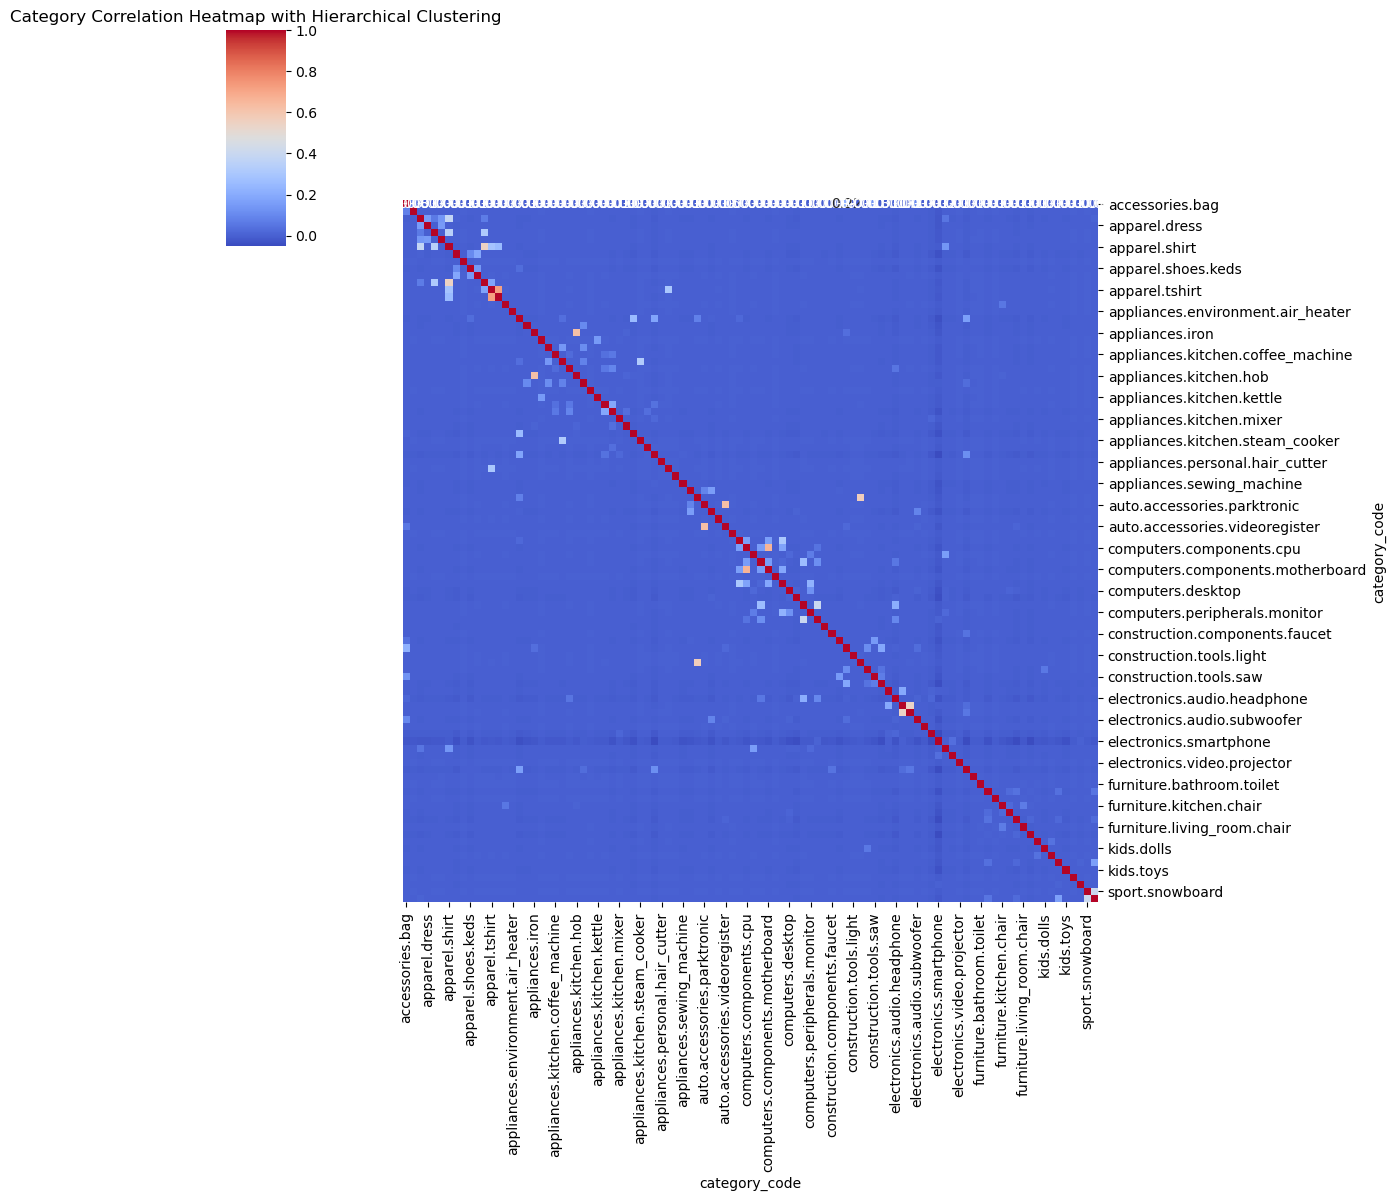

In [22]:
# Step 1: Create a cross-tabulation of user sessions and categories
category_crosstab = pd.crosstab(df['user_session'], df['category_code'])

# Step 2: Compute the correlation matrix
correlation_matrix = category_crosstab.corr()

# Step 3: Visualize the correlation matrix as a clustered heatmap
plt.figure(figsize=(12, 8))
sns.clustermap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', figsize=(12, 12), row_cluster=False, col_cluster=False)
plt.title('Category Correlation Heatmap with Hierarchical Clustering')
plt.show()


There are some interesting correlations between visits. Some of those could be expected based on product type, for example kids dolls and kids toys. But for example smart phones are always visited, no correlation with other categories.

For a successful analysis, we will need to group product_id by user_session to investigate which products are visited in the same session, leading to the suggestion that these products are related.

The core fields necessary for our recommendation system are fully populated, but there are missing data in 'brand' and 'category_code' columns. These missing values are not critical for our analysis as they do not impact the recommendation logic. Here are the results of the initial data inspection:

In [6]:
# Checking for nulls in each column
null_counts = df.isnull().sum()
print("Null counts per column:")
print(null_counts)

empty_product_ids = df[df['product_id'] == ''].shape[0]
empty_sessions = df[df['user_session'] == ''].shape[0]

print(f"Empty 'product_id' entries: {empty_product_ids}")
print(f"Empty 'user_session' entries: {empty_sessions}")


Null counts per column:
event_time              0
category_code    34073918
brand            14922708
product_id              0
user_id                 0
user_session            0
dtype: int64
Empty 'product_id' entries: 0
Empty 'user_session' entries: 0


In [7]:
sql_statement_count_by_hour = """
SELECT 
    EXTRACT(HOUR FROM event_time) AS hour_of_day,
    COUNT(*) AS event_count
FROM read_parquet('Data/views.parquet')
GROUP BY hour_of_day
ORDER BY hour_of_day
"""

# Connect to DuckDB and execute the SQL query
con = duckdb.connect(database=':memory:', read_only=False)
result = con.execute(sql_statement_count_by_hour).fetchdf()

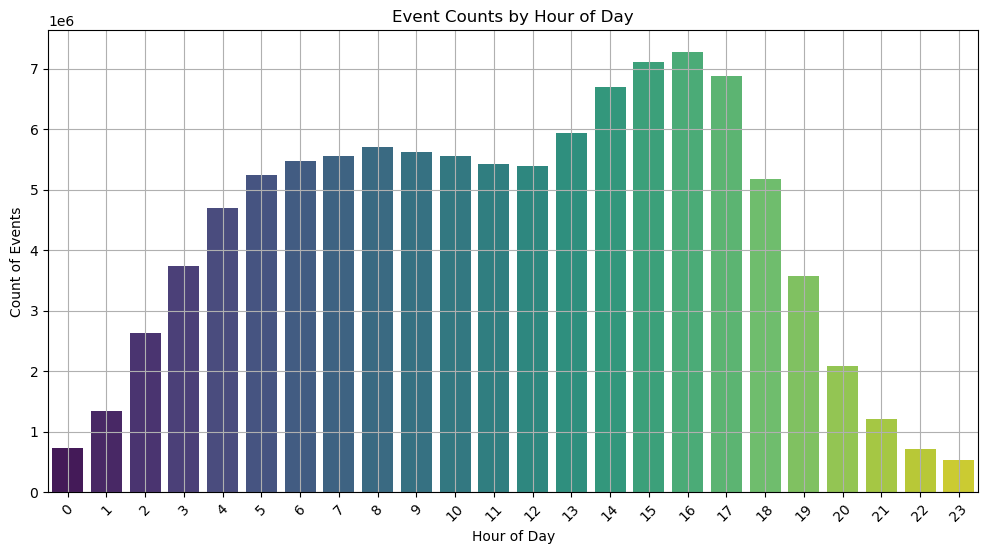

In [8]:
plt.figure(figsize=(12, 6))
sns.barplot(x=result['hour_of_day'], y=result['event_count'], palette="viridis")
plt.title('Event Counts by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Count of Events')
plt.xticks(rotation=45)  # Ensures that the hour labels are easy to read
plt.grid(True)
plt.show()

The most popular time of day is 16:00 hours, with a upgoing trend after lunch, but from the peak the drop off is rather significant.

In [9]:
sql_statement_top_products = """
WITH TopCategories AS (
    SELECT 
        category_code,
        COUNT(*) AS total_category_count
    FROM read_parquet('Data/views.parquet')
    GROUP BY category_code
    ORDER BY COUNT(*) DESC
    LIMIT 5
),
TopProducts AS (
    SELECT
        p.category_code,
        p.product_id,
        COUNT(*) AS product_count,
        tc.total_category_count,
        DENSE_RANK() OVER (PARTITION BY p.category_code ORDER BY COUNT(*) DESC) AS rank,
        ROUND(100.0 * COUNT(*) / tc.total_category_count, 2) AS pct
    FROM read_parquet('Data/views.parquet') p
    JOIN TopCategories tc ON p.category_code = tc.category_code
    GROUP BY p.category_code, p.product_id, tc.total_category_count
)
SELECT 
    category_code,
    product_count,
    total_category_count,
    pct,
    product_id
FROM TopProducts
WHERE rank <= 3
ORDER BY total_category_count DESC, category_code, rank
"""

con = duckdb.connect(database=':memory:', read_only=False)

# Execute the SQL statement
result = con.execute(sql_statement_top_products).fetchdf()

result

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,category_code,product_count,total_category_count,pct,product_id
0,electronics.smartphone,942167,25451835,3.70,1004856
1,electronics.smartphone,910725,25451835,3.58,1005115
2,electronics.smartphone,861675,25451835,3.39,1004767
3,electronics.clocks,82942,3267223,2.54,5100337
4,electronics.clocks,68257,3267223,2.09,5100577
5,electronics.clocks,66124,3267223,2.02,5100855
6,computers.notebook,102134,3209430,3.18,1307073
7,computers.notebook,84750,3209430,2.64,1307310
8,computers.notebook,59744,3209430,1.86,1307076
9,electronics.video.tv,200337,3127266,6.41,1801766


Our analysis of user engagement across product categories reveals distinct patterns in customer interest. Smartphones, Clocks, Notebooks, and TVs are the most popular categories identified. Notably, the concentration of views within these categories varies significantly. For instance, the top product within the Clocks category accounts for only 2.54% of the views at all Clocks, suggesting a diverse range of products attracting consumer attention. In contrast, the leading product in the TV category captures 6.41% of the views, indicating a more concentrated interest. This disparity highlights that some categories, like Clocks, exhibit a broader variety of products garnering interest compared to others, such as TVs, where a few products dominate the viewership.

Since we are working with visits, no further actions exist on outliers or scaling the dataset.

## Data preparation

We will now investigate and transform our dataframe into a format that can be directly utilized by our recommendation algorithms. We will group the product visited in each user_session:

In [10]:
unique_products_per_usersession = f"""
SELECT user_session, array_agg(DISTINCT product_id) AS product_ids
FROM '{file_name}'
GROUP BY user_session LIMIT 20
"""
duckdb.query(unique_products_per_usersession)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────┐
│     user_session     │                                          product_ids                                          │
│       varchar        │                                           varchar[]                                           │
├──────────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────┤
│ 3bfb58cd-7892-48cc…  │ [3601530]                                                                                     │
│ d67efe84-f47e-44dd…  │ [22700205, 22700007, 22700524, 22700324, 22700067]                                            │
│ 5cafe67a-3c46-4b47…  │ [3701016, 3701153, 4300291, 4300404, 3701244, 4300376, 3700769, 3701072, 4300343, 4300382]    │
│ b2da6f0a-6eeb-4502…  │ [2401540, 2401742]                                                                            │
│ a9e5a322-c765-d52d…  │ [270058

To optimize our recommendation system after identifying and removing sessions that contained only a single product view, we refined our approach by incorporating the count of visits to each product within a session. This modification is particularly effective when using matrix factorization techniques such as Alternating Least Squares (ALS) for generating recommendations.

Enhanced Recommendation through matrix factorisation and Count Metrics:

- Matrix Density and Weighting: matrix factorisation benefits from the inclusion of visit counts by treating these counts as implicit feedback. In the interaction matrix, multiple visits to a product increase the weight of that product's entry. This creates a denser and more informative matrix, where the frequency of interactions is directly proportional to user interest.
- Prioritization of Popular Products: By integrating visit counts, matrix factorisation naturally prioritizes products that receive more attention within user sessions. This is because matrix factorisation aims to minimize the reconstruction error of the original matrix, heavily influenced by entries (products) with higher weights (frequent visits). The algorithm adjusts product and user feature vectors to highlight products that are not only popular in general but also repeatedly viewed within sessions, ensuring these products are more likely to be recommended.
- Balancing User Preferences and Product Popularity: The inclusion of visit counts helps balance the intrinsic value of a product's popularity with individual user preferences. matrix factorisation modifies its factorization process to not just focus on sporadically viewed items but to emphasize products that consistently attract user interest, thereby aligning recommendations more closely with prevailing trends and user behaviors.

In [11]:
query = f"""
SELECT user_session, product_ids, product_counts
FROM (
    SELECT 
        user_session, 
        array_agg(product_id) AS product_ids,
        array_agg(product_count) AS product_counts
    FROM (
        SELECT 
            user_session, 
            product_id, 
            COUNT(*) AS product_count
        FROM '{file_name}'
        GROUP BY user_session, product_id
    ) sub
    GROUP BY user_session
    HAVING COUNT(product_id) > 1
) final;
"""

# Execute the query
products_in_session = duckdb.query(query).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

As we compile a comprehensive list of products viewed per session, the resulting data matrix naturally becomes large and predominantly filled with zeros, representing products not viewed in specific sessions. This extensive zero-fill leads to inefficient memory usage if handled as a full matrix. To optimize this, we convert the interaction data into a sparse matrix format, which is particularly suited for handling such datasets where non-zero entries are rare compared to the zeros.

Advantages of Using a Sparse Matrix:

- Memory Efficiency: Sparse matrices store only non-zero elements, significantly reducing memory requirements. This efficiency is crucial when dealing with millions of products and user sessions, where the vast majority of the matrix elements would otherwise be zeros.
- Computational Speed: Operations on sparse matrices are generally faster when it comes to algorithms designed to exploit their structure. This speed is due to the algorithms needing to process only the non-zero elements, bypassing the zeros entirely during calculations.
- Algorithm Compatibility: Most modern recommendation algorithms, particularly those used in collaborative filtering and machine learning for recommendation systems, are optimized to work with sparse matrix representations. This compatibility ensures that we can apply sophisticated analytical techniques directly on the sparse matrix without requiring additional transformations.

In [14]:
user_sessions = products_in_session['user_session'].tolist()
product_ids_list = products_in_session['product_ids'].tolist()
product_counts_list = products_in_session['product_counts'].tolist()

# Create mappings for rows (user_sessions) and columns (product_ids)
# These maps will retain the 'original' order or ID as keys and the matrix index as values
session_to_index = {session: idx for idx, session in enumerate(user_sessions)}
product_to_index = {}

# We need to ensure that all products have a unique index
current_index = 0
for products in product_ids_list:
    for product in products:
        if product not in product_to_index:
            product_to_index[product] = current_index
            current_index += 1

# Prepare data for the sparse matrix
row_indices = []
col_indices = []
data = []
for row_idx, products in enumerate(product_ids_list):
    counts = product_counts_list[row_idx]
    session_index = session_to_index[user_sessions[row_idx]]
    for product, count in zip(products, counts):
        product_index = product_to_index[product]
        row_indices.append(session_index)
        col_indices.append(product_index)
        data.append(count)

# Number of rows and columns
num_rows = len(session_to_index)
num_cols = len(product_to_index)

# Create the sparse matrix
matrix = sparse.coo_matrix((data, (row_indices, col_indices)), shape=(num_rows, num_cols))

To optimize and validate our recommendation system, we will distribute our sparse matrix data into three distinct sets: 80% for the training set, 10% for the validation set, and 10% for the test set. The training set will be used to build the model, while the validation set helps refine and adjust the model parameters without risking overfitting. The test set, kept separate from the tuning process, serves as the final measure of the model’s performance, providing insights into how it might perform under real-world conditions. This structure ensures robust training and fair evaluation, safeguarding against the model being overly tailored to specific sample characteristics.

In [15]:
def create_train_validation_test_splits(data_matrix, validation_pct=0.1, test_pct=0.1):
    # Ensure that the matrix is in COO format to simplify the splitting
    data_coo = data_matrix.tocoo()
    
    # Create a mask for all data points
    total_entries = data_coo.data.shape[0]
    train_mask = np.full(total_entries, True)
    
    # Define the size of the test and validation sets
    test_size = int(total_entries * test_pct)
    validation_size = int(total_entries * validation_pct)
    
    # Randomly choose data points to be in the test and validation sets
    total_indices = np.arange(total_entries)
    np.random.shuffle(total_indices)
    
    test_indices = total_indices[:test_size]
    validation_indices = total_indices[test_size:test_size + validation_size]
    
    # Update the train mask to exclude test and validation indices
    train_mask[test_indices] = False
    train_mask[validation_indices] = False
    
    # Create test, validation, and train matrices
    test_data = sparse.coo_matrix((data_coo.data[test_indices], 
                               (data_coo.row[test_indices], data_coo.col[test_indices])), 
                              shape=data_matrix.shape)
    
    validation_data = sparse.coo_matrix((data_coo.data[validation_indices], 
                                     (data_coo.row[validation_indices], data_coo.col[validation_indices])), 
                                    shape=data_matrix.shape)
    
    train_data = sparse.coo_matrix((data_coo.data[train_mask], 
                                (data_coo.row[train_mask], data_coo.col[train_mask])), 
                               shape=data_matrix.shape)
    
    return train_data, validation_data, test_data


train_data, validation_data, test_data = create_train_validation_test_splits(matrix)

## Model Selection

To enhance our recommendation system, we will deploy three models from the implicit library, each catering to different aspects of user-item interaction:

- Alternating Least Squares (ALS) [3]: This model decomposes the interaction matrix into two lower-dimensional matrices, one for user features and the other for product features, aiming to minimize the reconstruction error of the original matrix. ALS is efficient and scalable but may overfit and assumes linear interactions.
- Bayesian Personalized Ranking (BPR) [4]: BPR uses a pairwise ranking approach. It optimizes a pairwise loss function, which aims to correctly rank a user's preferred items higher than the less preferred ones. BPR is good at ranking but can be computationally intensive.
- Logistic Matrix Factorization [5]: A probabilistic approach incorporating logistic regression to predict the probability of interaction between users and items, providing a confidence score on predictions. It captures non-linear relationships and handles binary feedback well but may be less scalable and harder to optimize

These models will initially run in their default configurations. After the initial performance evaluation, we will optimise the best-performing model to enhance prediction accuracy.

### Scoring Metrics

We will utilize two metrics to assess the effectiveness of the models:

- Precision at K (where K=10): This metric measures the proportion of relevant recommended items in the top 10 (i.e., actually interacted with by users). It provides a straightforward indicator of recommendation relevance at a fixed list size.
- Mean Absolute Precision (MAP): MAP evaluates the average precision of predictions across all users, adjusting for both the rank of correctly recommended items and the confidence of the predictions. It penalizes errors in prediction and overly confident or insufficiently confident estimates, ensuring a balanced accuracy measure that reflects both aspects of user satisfaction.

In [ ]:
models = [
    {"label": "ALS", "model": implicit.als.AlternatingLeastSquares, "params": {}},
    {"label": "BPR", "model": implicit.bpr.BayesianPersonalizedRanking, "params": {}},
    {"label": "LMF", "model": implicit.lmf.LogisticMatrixFactorization, "params": {}}
]
results = []

# Function to run and evaluate a model
def run_and_evaluate_model(model, label, train_data, validation_data, K=10):
    model.fit(train_data)
    avg_precision= precision_at_k(model, train_data, validation_data)
    mean_avg_prec = mean_average_precision_at_k(model, train_data, validation_data)
    return {"Model": label, "Precision@10": avg_precision, "MAP@10": mean_avg_prec}

# Iterate over the models and collect results
if RERUN: 
    for model_info in models:
        model_instance = model_info["model"](**model_info["params"])
        result = run_and_evaluate_model(model_instance, model_info["label"], train_data, validation_data)
        results.append(result)

    # Create DataFrame from the results
    results_df = pd.DataFrame(results)
    print(results_df)

Small training set:
| Model | Precision@10 | MAP@10    |
|-------|--------------|-----------|
| ALS   | 0.082051     | 0.050657  |
| BPR   | 0.000000     | 0.000000  |
| LMF   | 0.066667     | 0.045632  |

Using these models on the full dataset:
| Model | Precision@10 | MAP@10    |
|-------|--------------|-----------|
| ALS   | 0.120611     | 0.059842  |
| BPR   | 0.087190     | 0.037055  |
| LMF   | 0.019175     | 0.006370  |

There were some interesting observations:
1. ALS outperformed the other models and increased in performance when more information was available.
1. Bayes personalized ranking did not have enough information in the small sample size but scored similarly on the large dataset as ALS did on the small dataset. This means the model was implemented correctly
2. LMF reduced performance when it was shown more information

We have established that ALS better fits this data, so let's optimise the parameters. The top 3 parameters we decided to improve:
1. Factors: the resolution of the matrix. We made a mistake here where the small test set could handle more factors (because it was smaller) than the full dataset.
2. The regularization: How much a deviation was punished.
3. Alpha: How a positive sample (visited) was weighted against a negative sample.

The final two are sampled from a log-uniform space. This means that we assume that the difference between 100 and 1000 is just as great as the difference between 1000 and 10,000, which helps limit the search space.

In [ ]:

# Define the space of hyperparameters to optimize
space = [
    Integer(100, 250, name='factors'),
    Real(1000, 100000, prior='log-uniform', name='regularization'),
    Real(1000, 100000, prior='log-uniform', name='alpha')
]

train_data = train_data.tocsr()

# Define the objective function to minimize
@use_named_args(space)
def objective(**params):
    model = implicit.als.AlternatingLeastSquares(**params)
    model.fit(train_data)
    score = precision_at_k(model, train_data, validation_data)
    return -score  # Negative because gp_minimize seeks to minimize the function

# Run the optimization
if RERUN:
    res = gp_minimize(objective, space, n_calls=100, random_state=0, verbose=True)

print("Best parameters:", res.x)
print("Best validation score:", -res.fun)


The best parameters found were: 
- Factors: 250
- Regularization: 2755
- Alpha: 3076

In [20]:
optimal_params = {
    'factors': 250,
    'regularization': 2755,
    'alpha': 3076
}
model = implicit.als.AlternatingLeastSquares(**optimal_params)
if RERUN:
    model.fit(train_data)

c:\Users\jjzd8\anaconda3\Lib\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 1.1590793132781982 seconds
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

When we first ran the algorhytm on the small dataset we managed to increase the precision at 10 from 0.120 baseline to 0.124 with optimal parameters. Running the full dataset increased the score to 0.208, showing how a bigger dataset enhanced the understanding of the model.

In [38]:
if RERUN:
    precision_at_k(model, train_data, validation_data)

  0%|          | 0/4081281 [00:00<?, ?it/s]

0.20788149479149493

In [22]:
if RERUN:
    test_results = precision_at_k(model, train_data, test_data)
print(test_results)

  0%|          | 0/4080829 [00:00<?, ?it/s]

0.20692575820616715


| Dataset        | Precision @ 10|
|----------------|---------------|
| Validation-set | 20.8%         |
| Test-set       | 20.7%         |


The final run on the data never used before (aka the test set) revealed a real-life score of 0.207. This is similar but a tiny bit lower than our validation set. This shows how the validation set becomes part of the training process.

## Conclusion

We successfully developed a recommendation system using a laptop setup capable of processing over 11 million user-product interactions. By employing and optimising the Alternating Least Squares (ALS) algorithm, we recommended ten products, two of which were verified against actual user visits in our test dataset. This resulted in a precision score of 20.7% in real-world conditions.

## Discussion

The project was executed smoothly, showing a marked improvement in implementing machine learning models over my previous experiences with supervised models. A key lesson learned was the importance of leveraging the full count of visits without reducing it to a binary classification problem. Additionally, continuous testing of the model throughout the analysis is crucial to avoid selecting parameters that, when scaled up to the full dataset, could lead to memory constraints.

Looking forward, considering both products viewed and products subsequently purchased could yield a more practical and realistic recommendation system. Additionally, the performance of Logistic Matrix Factorization was underwhelming, especially with increased data volume, suggesting a potential mismatch between model assumptions and our specific data structure. Adapting techniques used in other domains, such as Spotify’s approach to music recommendation, which involves categorising genres and artists, could enhance our model's relevance and accuracy by incorporating the category code into the analysis. This would also involve more data engineering since we would have to deal with the missing data in this field.

## References:
1: https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store \
2: https://rees46.com/en/open-cdp \
3: Fast Matrix Factorization for Online Recommendation with Implicit Feedback, He et al, 2017 \
4: BPR: Bayesian Personalized Ranking from Implicit Feedback, Rendle et al, 2009 \
5: Logistic Matrix Factorization for Implicit Feedback Data, Johnson, 2014